In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews 
! unzip imdb-dataset-of-50k-movie-reviews.zip 

 35% 9.00M/25.7M [00:00<00:01, 17.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 38.5MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [5]:
df = pd.read_csv("IMDB Dataset.csv")

In [6]:
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [7]:
reviews = df['review']
sentiments = df['sentiment']

In [8]:
sentiment=[]

for i in sentiments:
  if i=='positive':
    sentiment.append(1)
  else:
    sentiment.append(0)


print(sentiment[:3])

[1, 1, 1]


In [9]:
df.shape

(50000, 2)

In [10]:
num_train = int(0.81*len(reviews))
num_val = int(0.90*len(reviews))

train_reviews = reviews[:num_train]
val_reviews = reviews[num_train:num_val]
test_reviews = reviews[num_val:]

train_labels = np.array(sentiment[:num_train])
val_labels = np.array(sentiment[num_train:num_val])
test_labels = np.array(sentiment[num_val:])

In [11]:
length = []

for i in reviews:
  length.append(len(i))


print(max(length))
print(min(length))
print(sum(length) / len(length))

13704
32
1309.43102


In [12]:
vocab_size = 50000
max_length = 1000
trunc_type = 'post'
oov_tok = "<UNK>"

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)
word_index = tokenizer.word_index
print(word_index)

{'<UNK>': 1, 'the': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'br': 8, 'in': 9, 'it': 10, 'i': 11, 'this': 12, 'that': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'movie': 18, 'but': 19, 'film': 20, 'on': 21, 'not': 22, 'you': 23, 'are': 24, 'his': 25, 'have': 26, 'be': 27, 'one': 28, 'he': 29, 'all': 30, 'at': 31, 'by': 32, 'an': 33, 'they': 34, 'so': 35, 'who': 36, 'from': 37, 'like': 38, 'or': 39, 'just': 40, 'her': 41, 'about': 42, 'out': 43, 'if': 44, "it's": 45, 'has': 46, 'some': 47, 'there': 48, 'what': 49, 'good': 50, 'more': 51, 'when': 52, 'very': 53, 'up': 54, 'no': 55, 'time': 56, 'my': 57, 'even': 58, 'would': 59, 'she': 60, 'which': 61, 'only': 62, 'really': 63, 'see': 64, 'story': 65, 'their': 66, 'had': 67, 'can': 68, 'me': 69, 'well': 70, 'were': 71, 'than': 72, 'much': 73, 'we': 74, 'bad': 75, 'been': 76, 'get': 77, 'great': 78, 'do': 79, 'will': 80, 'other': 81, 'also': 82, 'into': 83, 'because': 84, 'people': 85, 'how': 86, 'first': 87, 'him': 88, 'most':

In [14]:
train_sequences = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_reviews)
val_padded = pad_sequences(val_sequences, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [15]:
print(type(train_sequences))
print(type(train_padded))

<class 'list'>
<class 'numpy.ndarray'>


In [16]:
embedding_dim=128

model = keras.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(128, 5, activation='relu'))
#model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
model.add(layers.Bidirectional(layers.GRU(128)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.01)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         6400000   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          82048     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,696,705
Trainable params: 6,696,705
Non-trainable params: 0
______________________________________________

In [17]:
keras.backend.clear_session()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_padded, train_labels, 
                    epochs=25, batch_size=128, 
                    validation_data=(val_padded, val_labels),
                    callbacks=[keras.callbacks.ModelCheckpoint('imdb.keras', save_best_only=True)])

Epoch 1/25
317/317 [==============================] - 50s 98ms/step - loss: 0.4252 - accuracy: 0.7945 - val_loss: 0.2525 - val_accuracy: 0.8982
Epoch 2/25
317/317 [==============================] - 34s 106ms/step - loss: 0.1762 - accuracy: 0.9347 - val_loss: 0.2954 - val_accuracy: 0.8816
Epoch 3/25
317/317 [==============================] - 30s 95ms/step - loss: 0.0830 - accuracy: 0.9724 - val_loss: 0.2764 - val_accuracy: 0.9078
Epoch 4/25
317/317 [==============================] - 31s 97ms/step - loss: 0.0372 - accuracy: 0.9884 - val_loss: 0.3486 - val_accuracy: 0.9027
Epoch 5/25
317/317 [==============================] - 30s 95ms/step - loss: 0.0166 - accuracy: 0.9949 - val_loss: 0.4591 - val_accuracy: 0.8936
Epoch 6/25
317/317 [==============================] - 30s 95ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.4782 - val_accuracy: 0.8976
Epoch 7/25
317/317 [==============================] - 30s 95ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.5543 - val_accuracy

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

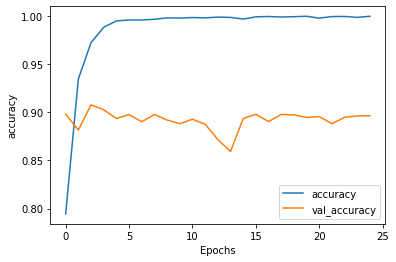

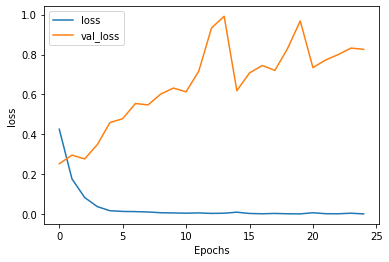

In [19]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')